In [1]:
import os
import glob
import cv2
import imghdr
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

ModuleNotFoundError: No module named 'cv2'

In [12]:
# Limit the VRAM that Tensor Flow can use on my GPU. 
# This avoids any potential OOM (Out of Memory) errors through setting the GPU Memory Consumption Growth.
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
data_dir = 'data'

In [14]:
image_exts = ['jpeg', 'tiff']

In [15]:
for image_class in os.listdir(data_dir): 
    if (image_class != '.DS_Store'):
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
            try: 
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts: 
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e: 
                print('Issue with image {}'.format(image_path))
                # os.remove(image_path)

In [16]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 370 files belonging to 34 classes.


In [17]:
data_iterator = data.as_numpy_iterator()

In [18]:
batch = data_iterator.next()
batch[0].shape

(32, 256, 256, 3)

In [19]:
data = data.map(lambda x,y: (x/255, y))
data

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
data.as_numpy_iterator().next()

(array([[[[0.99163604, 0.46614584, 0.56026345],
          [0.99607843, 0.47058824, 0.5647059 ],
          [0.9973805 , 0.47189033, 0.56992954],
          ...,
          [0.9909314 , 0.53995097, 0.6693627 ],
          [0.99682903, 0.5401501 , 0.67242646],
          [0.99963236, 0.5368872 , 0.6702206 ]],
 
         [[0.9917892 , 0.46629903, 0.56041664],
          [0.9996477 , 0.47415748, 0.5686275 ],
          [1.        , 0.48653492, 0.58457416],
          ...,
          [1.        , 0.5577053 , 0.68711704],
          [0.99682903, 0.54584867, 0.6752604 ],
          [0.9964001 , 0.54541975, 0.6748315 ]],
 
         [[0.99240196, 0.46691176, 0.56102943],
          [0.9844516 , 0.4589614 , 0.55589765],
          [0.9892157 , 0.46372548, 0.5617647 ],
          ...,
          [0.98483455, 0.5338542 , 0.66326594],
          [1.        , 0.5512255 , 0.68063724],
          [0.9961244 , 0.545144  , 0.6745558 ]],
 
         ...,
 
         [[0.8226869 , 0.23053002, 0.35209864],
          [0.82758

In [21]:
train_size = int(len(data)*.6)
val_size = int(len(data)*.25)
test_size = int(len(data)*.15)

In [22]:
val_size

3

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [24]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [25]:
def encode_one_hot(image, label):
    label = tf.one_hot(label, depth=34)
    return image, label

train = train.map(encode_one_hot)
val = val.map(encode_one_hot)

In [26]:
model = Sequential()

In [27]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(34, activation='sigmoid'))

In [28]:
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [30]:
logdir='logs'

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
7/7 [==============================] - 2s 273ms/step - loss: 3.5515 - accuracy: 0.0491 - precision: 0.0328 - recall: 0.5714 - val_loss: 3.5076 - val_accuracy: 0.1042 - val_precision: 0.0397 - val_recall: 0.5938
Epoch 2/15
7/7 [==============================] - 2s 237ms/step - loss: 3.4706 - accuracy: 0.0536 - precision: 0.0395 - recall: 0.6607 - val_loss: 3.4312 - val_accuracy: 0.0625 - val_precision: 0.0366 - val_recall: 0.6562
Epoch 3/15
7/7 [==============================] - 2s 244ms/step - loss: 3.3161 - accuracy: 0.0893 - precision: 0.0442 - recall: 0.7455 - val_loss: 3.1460 - val_accuracy: 0.1250 - val_precision: 0.0498 - val_recall: 0.7812
Epoch 4/15
7/7 [==============================] - 2s 248ms/step - loss: 3.0345 - accuracy: 0.2009 - precision: 0.0522 - recall: 0.7991 - val_loss: 2.9175 - val_accuracy: 0.2396 - val_precision: 0.0566 - val_recall: 0.8125
Epoch 5/15
7/7 [==============================] - 2s 259ms/step - loss: 2.6487 - accuracy: 0.2946 - precision: 0

In [33]:
print(hist.history)

print("\nFinal Training Loss: ", hist.history['loss'][-1])
print("Final Training Accuracy: ", hist.history['accuracy'][-1])
print("Final Training Precision: ", hist.history['precision'][-1])
print("Final Training Recall: ", hist.history['recall'][-1])
print("Final Validation Loss: ", hist.history['val_loss'][-1])
print("Final Validation Accuracy: ", hist.history['val_accuracy'][-1])
print("Final Validation Precision: ", hist.history['val_precision'][-1])
print("Final Validation Recall: ", hist.history['val_recall'][-1])

{'loss': [3.5514767169952393, 3.4705753326416016, 3.3161022663116455, 3.034489870071411, 2.648729085922241, 2.2912216186523438, 1.787023901939392, 1.4002268314361572, 1.0670276880264282, 1.0860384702682495, 0.9303001165390015, 0.8030288815498352, 0.5738444328308105, 0.5158097147941589, 0.47647005319595337], 'accuracy': [0.0491071417927742, 0.0535714291036129, 0.0892857164144516, 0.2008928507566452, 0.2946428656578064, 0.40625, 0.5669642686843872, 0.5714285969734192, 0.6294642686843872, 0.6875, 0.75, 0.7366071343421936, 0.8571428656578064, 0.8526785969734192, 0.8928571343421936], 'precision': [0.03279528394341469, 0.039519358426332474, 0.04420328140258789, 0.052232272922992706, 0.05708370357751846, 0.05845881253480911, 0.06190885603427887, 0.06761786341667175, 0.07425907254219055, 0.07615437358617783, 0.07762237638235092, 0.07772380113601685, 0.07816333323717117, 0.08107130229473114, 0.07463186234235764], 'recall': [0.5714285969734192, 0.6607142686843872, 0.7455357313156128, 0.799107134

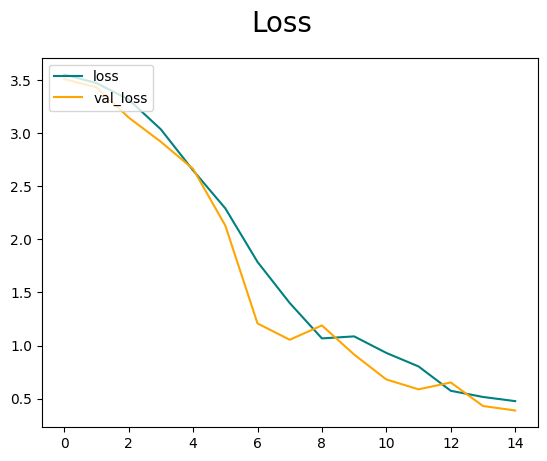

In [34]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

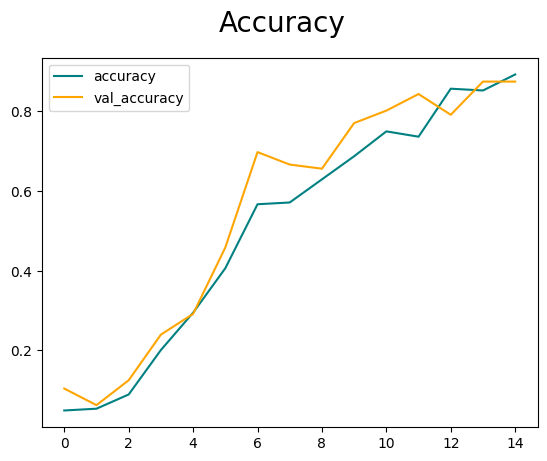

In [35]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [36]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [37]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    y_one_hot = tf.one_hot(y, depth=34)
    pre.update_state(y_one_hot, yhat)
    re.update_state(y_one_hot, yhat)
    acc.update_state(y_one_hot, yhat)

1/1 [==============================] - 0s 111ms/step


In [38]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.07862408, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.6553309, shape=(), dtype=float32)


In [51]:
model.save(os.path.join('models','leafclassifier_v4b.h5'))

In [52]:
new_model = load_model(os.path.join('models','leafclassifier_v4b.h5'))